# Assignment 1-2: Support Vector Machine

## Multiclass Support Vector Machine exercise


In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient


## CIFAR-10 Data Loading and Preprocessing

# Libraries requre for run the program


In [3]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings 
warnings.filterwarnings('ignore')

In [5]:
# Load the data &Extract the data from Cifar 10
import os
import urllib.request
import tarfile
import pickle
import numpy as np

# Function to show download progress
def show_progress(count, block_size, total_size):
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    print(msg, end='')

# Function to download and extract the dataset
def download_and_unpack(url, target_dir):
    """
    Downloads and extracts the CIFAR-10 dataset if not already present.

    :param url: The URL of the file to download.
    :param target_dir: The directory where the file will be saved and extracted.
    """
    file_name = url.split('/')[-1]
    file_path = os.path.join(target_dir, file_name)

    if not os.path.exists(file_path):
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)

        print(f"Downloading {file_name}...")
        file_path, _ = urllib.request.urlretrieve(url=url, filename=file_path, reporthook=show_progress)
        print("\nDownload completed. Extracting files...")

        if file_path.endswith(".tar.gz"):
            with tarfile.open(name=file_path, mode="r:gz") as tar_ref:
                tar_ref.extractall(target_dir)
        print("Extraction done.")
    else:
        print("File already downloaded and extracted.")

# Function to load CIFAR-10 batch data
def load_batch(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
        X = data_dict[b'data']
        Y = data_dict[b'labels']
        X = X.reshape(10000, 3, 32, 32).astype("float")
        Y = np.array(Y)
    return X, Y

# Function to load the CIFAR-10 dataset
def load_cifar10(data_dir):
    """
    Loads the entire CIFAR-10 dataset from the given directory.

    :param data_dir: The directory where the CIFAR-10 data is located.
    :return: Tuple of numpy arrays (X_train, Y_train), (X_test, Y_test)
    """
    # Load all the training batches
    X_train = []
    Y_train = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, 'data_batch_' + str(i))
        X, Y = load_batch(batch_file)
        X_train.append(X)
        Y_train.append(Y)
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)

    # Load the test batch
    X_test, Y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    return (X_train, Y_train), (X_test, Y_test)

# Define URL and download directory
download_dir = r"C:\Users\jasha\OneDrive\cifar-10-batches-py"  # Replace with your directory
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

# Download and extract CIFAR-10 dataset
download_and_unpack(url, download_dir)

# Load the dataset
data_dir = os.path.join(download_dir, 'cifar-10-batches-py')
(X_train, Y_train), (X_test, Y_test) = load_cifar10(data_dir)

# Check the data shapes
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {Y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {Y_test.shape}")


File already downloaded and extracted.
Training data shape: (50000, 3, 32, 32)
Training labels shape: (50000,)
Test data shape: (10000, 3, 32, 32)
Test labels shape: (10000,)


In [6]:
# UPLOAD THE DATA ON ONE DRIVE

# Define the download directory and URL
download_dir = r"C:\Users\jasha\OneDrive\cifar-10-batches-py"
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"  # URL for CIFAR-10 dataset

# Call the function to download and extract
download_and_unpack(url, download_dir)

File already downloaded and extracted.


In [7]:
# Start the  Data preprocessing

#LOAD CIFAR-10 DATASET
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Check the shape of the loaded data
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [8]:
# Normalize the images to values between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Verify the normalization by printing the minimum and maximum values
print(f"Min pixel value in x_train: {x_train.min()}")
print(f"Max pixel value in x_train: {x_train.max()}")


Min pixel value in x_train: 0.0
Max pixel value in x_train: 1.0


In [9]:
# Performing the one _hot encoding
from tensorflow.keras.utils import to_categorical 

# One-hot encode the labels for training and test datasets
y_train = to_categorical(Y_train, num_classes=10)  
y_test = to_categorical(Y_test, num_classes=10)   

# Check the shape of the one-hot encoded labels
print(f"y_train shape after one-hot encoding: {y_train.shape}")  
print(f"Example of one-hot encoded label: {y_train[0]}")  





y_train shape after one-hot encoding: (50000, 10)
Example of one-hot encoded label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [11]:
# create a small development set as a subset of the training data;
import numpy as np
from tensorflow.keras.datasets import cifar10

# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Define the number of samples for each subset
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Split the original training data into training and validation sets
# Validation set: from num_training to num_training + num_validation
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Training set: first num_training points
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Development set: random subset of training data (500 samples)
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# Test set: first num_test points from the original test set
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

# Print the shapes of the datasets to verify the splits
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000, 1)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000, 1)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000, 1)
Dev data shape:  (500, 32, 32, 3)
Dev labels shape:  (500, 1)


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing: subtract the mean image
# 1: Create the mean image on the base of training data
mean_img = np.mean(train_data, axis=0)  # changed X_train to train_data
print(mean_img[:10])  # print a few of the elements

plt.figure(figsize=(4, 4))
plt.imshow(mean_img.reshape((32, 32, 3)).astype('uint8'))  # visualize the mean image
plt.show()

# 2: Subtract the mean image from training, validation, test, and development data
train_data -= mean_img  # changed X_train to train_data
val_data -= mean_img  # changed X_val to val_data
test_data -= mean_img  # changed X_test to test_data
dev_data -= mean_img  # changed X_dev to dev_data

# Third: Append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
train_data = np.hstack([train_data, np.ones((train_data.shape[0], 1))])  # X_train -> train_data
val_data = np.hstack([val_data, np.ones((val_data.shape[0], 1))])  # X_val -> val_data
test_data = np.hstack([test_data, np.ones((test_data.shape[0], 1))])  # X_test -> test_data
dev_data = np.hstack([dev_data, np.ones((dev_data.shape[0], 1))])  # X_dev -> dev_data

print(train_data.shape, val_data.shape, test_data.shape, dev_data.shape)


NameError: name 'train_data' is not defined

Mean image (first 10 elements): [[[130.71074 136.05614 132.5538 ]
  [130.14036 135.44238 131.85358]
  [131.05044 136.24616 132.58144]
  [131.56886 136.67804 132.8775 ]
  [132.1847  137.22858 133.26738]
  [132.85184 137.8545  133.78034]
  [133.37154 138.28386 134.15504]
  [133.89092 138.74072 134.5227 ]
  [134.48504 139.27524 135.01422]
  [134.9326  139.6326  135.29142]
  [135.23398 139.94098 135.51004]
  [135.40374 140.0906  135.659  ]
  [135.62016 140.26882 135.81572]
  [135.63418 140.26172 135.80778]
  [135.63402 140.22544 135.7769 ]
  [135.61138 140.17206 135.71862]
  [135.53046 140.09332 135.58066]
  [135.5036  140.06138 135.55468]
  [135.49102 140.05346 135.5742 ]
  [135.38346 139.96092 135.47278]
  [135.10962 139.71384 135.20938]
  [134.9583  139.6188  135.177  ]
  [134.8102  139.49842 135.10764]
  [134.52658 139.29726 134.92798]
  [134.04618 138.94646 134.62446]
  [133.6069  138.58728 134.33616]
  [133.0759  138.10716 133.93838]
  [132.32476 137.4154  133.3761 ]
  [131.58878 136

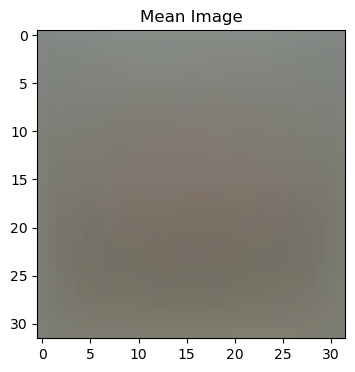

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 2 dimension(s)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

# Split test_data into validation and test sets
val_data = test_data[:5000]
test_data = test_data[5000:]

# Create a small development set
dev_data = train_data[:1000]  # Subset of train_data for development purposes

# Preprocessing: subtract the mean image
# 1: Create the mean image based on training data
mean_img = np.mean(train_data, axis=0)
print("Mean image (first 10 elements):", mean_img[:10])  # print a few of the elements

# Visualize the mean image
plt.figure(figsize=(4, 4))
plt.imshow(mean_img.reshape((32, 32, 3)).astype('uint8'))  # visualize the mean image
plt.title('Mean Image')
plt.show()

# 2: Subtract the mean image from training, validation, test, and development data
train_data = train_data - mean_img
val_data = val_data - mean_img
test_data = test_data - mean_img
dev_data = dev_data - mean_img

# 3: Append the bias dimension of ones (bias trick)
train_data = np.hstack([train_data, np.ones((train_data.shape[0], 1))])
val_data = np.hstack([val_data, np.ones((val_data.shape[0], 1))])
test_data = np.hstack([test_data, np.ones((test_data.shape[0], 1))])
dev_data = np.hstack([dev_data, np.ones((dev_data.shape[0], 1))])

# Print the shapes of the processed datasets
print("Shapes after processing:")
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)
print("Development data shape:", dev_data.shape)


## SVM Classifier

You need to complete `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [18]:
from builtins import range
import numpy as np
from random import shuffle
from past.builtins import xrange

def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape) # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1 # note delta = 1
            if margin > 0:
                loss += margin

    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss /= num_train

    # Add regularization to the loss.
    loss += reg * np.sum(W * W)

    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather than first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################
    # *****START OF YOUR CODE*****

    pass

    # *****END OF YOUR CODE*****
    
    return loss, dW

In [20]:
import numpy as np

# Generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

# Flatten X_dev from (32, 32, 3) to (num_samples, 3072) and append bias trick
X_dev = X_dev.reshape(X_dev.shape[0], -1)
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])  # Shape should be (num_samples, 3073)

# Assume y_dev is already loaded correctly and has the correct shape (num_samples,)
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)

print('loss: %f' % (loss,))


loss: 10.425408


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [1]:
import numpy as np
from gradient_check import grad_check_sparse

def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength.

    Returns a tuple of:
    - loss as a single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape)  # initialize the gradient as zero
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0

    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1  # note delta = 1
            if margin > 0:
                loss += margin
                dW[:, j] += X[i]
                dW[:, y[i]] -= X[i]

    # Average loss and gradient
    loss /= num_train
    dW /= num_train

    # Add regularization to the loss and gradient
    loss += 0.5 * reg * np.sum(W * W)
    dW += reg * W

    return loss, dW

# Initialize variables
np.random.seed(0)
W = np.random.randn(3073, 10) * 0.0001  # Example weight matrix (D, C)
X_dev = np.random.randn(50, 3073)       # Example data (N, D)
y_dev = np.random.randint(10, size=50)  # Example labels (N,)

# Compute loss and gradient without regularization
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Define a function that returns loss for gradient checking
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]

# Perform gradient check without regularization
grad_numerical = grad_check_sparse(f, W, grad)

# Compute loss and gradient with regularization
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)

# Define a function that returns loss for gradient checking with regularization
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]

# Perform gradient check with regularization
grad_numerical = grad_check_sparse(f, W, grad)


ModuleNotFoundError: No module named 'gradient_check'

In [23]:
import sys
sys.path.append('/path/to/directory/containing/gradient_check')
from gradient_check import grad_check_sparse


ModuleNotFoundError: No module named 'gradient_check'

In [4]:
import numpy as np

def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function with regularization, naive implementation (with loops).
    
    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels.
    - reg: (float) regularization strength.

    Returns a tuple of:
    - loss: A single float representing the loss
    - dW: The gradient with respect to weights W, same shape as W
    """
    dW = np.zeros(W.shape)  # Initialize gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    
    # Compute the loss and the gradient
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1  # Delta = 1
            if margin > 0:
                loss += margin
                dW[:, j] += X[i]  # Accumulate gradient for incorrect class
                dW[:, y[i]] -= X[i]  # Accumulate gradient for correct class
    
    # Average the loss and gradient
    loss /= num_train
    dW /= num_train

    # Regularization: Add regularization to the loss
    loss += 0.5 * reg * np.sum(W * W)

    # Regularization: Add gradient of regularization term
    dW += reg * W

    return loss, dW

# Example test case to verify the loss with regularization

# Initialize random weights and data
np.random.seed(0)
W = np.random.randn(3073, 10) * 0.0001  # Example weight matrix (D, C)
X_dev = np.random.randn(50, 3073)       # Example data (N, D)
y_dev = np.random.randint(10, size=50)  # Example labels (N,)

# Compute loss and gradient with regularization
reg_strength = 5e1  # Example regularization strength (lambda)
loss, grad = svm_loss_naive(W, X_dev, y_dev, reg_strength)

# Output the results
print(f"Loss with regularization: {loss}")
print(f"Gradient with regularization (first 5 rows, 5 columns):\n{grad[:5, :5]}")


Loss with regularization: 9.018263694641654
Gradient with regularization (first 5 rows, 5 columns):
[[ 0.45896767  0.51263295 -0.45695758  0.34012832  0.37513293]
 [ 0.84239999  0.00633881  0.01997765  0.35947004 -0.13964541]
 [-0.2158925   0.47502084 -0.31442936  0.0087179   0.47925636]
 [ 0.10311758 -0.11379617 -0.62758659  0.17152457 -0.18042518]
 [ 0.11492964 -0.53192143  0.66701926  0.38379621 -0.56721553]]


In [27]:
import numpy as np

#  Initialize random weights for W (small random values)

W = np.random.randn(3073, 10) * 0.0001

#  Compute the loss and the gradient using the naive SVM loss function, without regularization

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Print
print(f"Initial loss without regularization: {loss}")

def loss_function_no_reg(w):
    return svm_loss_naive(w, X_dev, y_dev, 0.0)[0]  # We only need the loss (first element of the tuple)

# gradient check function

def grad_check_sparse(f, W, grad, num_checks=10, h=1e-5):
    """
    This function checks the gradient by comparing the numerical approximation with the analytical gradient.
    
    Parameters:
    - f: the function that computes the loss (should return only the loss)
    - W: the current weights
    - grad: the analytical gradient that we computed
    - num_checks: the number of random gradient components to check (default is 10)
    - h: the small step size for numerical gradient approximation (default is 1e-5)
    """
    print("\nPerforming gradient check...\n")
    
    # Loop over the number of gradient checks 
    for i in range(num_checks):
        # Randomly select an index within the shape of W (tuple of coordinates)
        ix = tuple([np.random.randint(m) for m in W.shape])
        
        # Save the original value at the randomly selected index
        oldval = W[ix]
        
        W[ix] = oldval + h
        fxph = f(W)  # Loss for W + h
        
        
        W[ix] = oldval - h
        fxmh = f(W)  # Loss for W - h
        W[ix] = oldval
        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = grad[ix]
        
        # relative error between the numerical and analytical gradients
        rel_error = abs(grad_numerical - grad_analytic) / max(1e-8, abs(grad_numerical) + abs(grad_analytic))
        
        # Print the numerical gradient, analytical gradient, and relative error for the selected index
        print(f"Index {ix}: numerical: {grad_numerical}, analytic: {grad_analytic}, relative error: {rel_error}")

#Perform the gradient check without regularization
grad_check_sparse(loss_function_no_reg, W, grad)

loss_reg, grad_reg = svm_loss_naive(W, X_dev, y_dev, 5e1)

# Print the loss with regularization
print(f"Loss with regularization: {loss_reg}")

def loss_function_with_reg(w):
    return svm_loss_naive(w, X_dev, y_dev, 5e1)[0]  # We only need the loss (first element of the tuple)

# Step 8: Perform the gradient check with regularization
grad_check_sparse(loss_function_with_reg, W, grad_reg)

# Step 9: End of the gradient check
print("Gradient @done!")


Initial loss without regularization: [9.3386983]

Performing gradient check...

Index (1240, 4): numerical: [-19.014], analytic: 0.0, relative error: [1.]
Index (509, 0): numerical: [-83.288], analytic: 0.0, relative error: [1.]
Index (733, 9): numerical: [50.48430516], analytic: 0.0, relative error: [1.]
Index (371, 2): numerical: [94.968], analytic: 0.0, relative error: [1.]
Index (347, 0): numerical: [-86.182], analytic: 0.0, relative error: [1.]
Index (504, 4): numerical: [0.918], analytic: 0.0, relative error: [1.]
Index (3040, 1): numerical: [-6.61943468], analytic: 0.0, relative error: [1.]
Index (894, 7): numerical: [6.55212952], analytic: 0.0, relative error: [1.]
Index (1068, 2): numerical: [90.768], analytic: 0.0, relative error: [1.]
Index (937, 7): numerical: [5.068], analytic: 0.0, relative error: [1.]
Loss with regularization: [9.35395398]

Performing gradient check...

Index (2096, 8): numerical: [-15.42681729], analytic: 0.0, relative error: [1.]
Index (1849, 2): numer

In [31]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    # *****START OF YOUR CODE*****

    pass

    # *****END OF YOUR CODE*****

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################
    # *****START OF YOUR CODE*****

    pass

    # *****END OF YOUR CODE*****

    return loss, dW


In [29]:
import numpy as np

def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength.

    Returns:
    - loss: (float) the SVM loss
    - dW: (numpy array) gradient of the loss with respect to W, of the same shape as W
    """

    
    dW = np.zeros(W.shape)  # Initialize the loss and gradient

   Compute the scores for all classes
    scores = X.dot(W)  
 
    # Step 2: Get the correct class scores (for each row, select the score corresponding to the correct class)
    correct_class_scores = scores[np.arange(X.shape[0]), y].reshape(-1, 1)  # Shape (N, 1)

    # Step 3: Calculate the margins
    margins = np.maximum(0, scores - correct_class_scores + 1)  # Shape (N, C)
    margins[np.arange(X.shape[0]), y] = 0  # No loss for the correct class

    # Step 4: Compute the loss
    loss = np.sum(margins) / X.shape[0]  # Take the mean of the sum of margins
    loss += reg * np.sum(W * W)  # Add regularization term to the loss

    # Step 5: Compute the gradient
    binary = (margins > 0).astype(float)  # Binary mask of where the margins are positive
    row_sum = np.sum(binary, axis=1)  # Sum of positive margins for each data point
    binary[np.arange(X.shape[0]), y] = -row_sum  # Adjust for the correct classes

    # Compute the gradient using the binary mask
    dW = X.T.dot(binary) / X.shape[0]  # Calculate gradient
    dW += 2 * reg * W  # Add the regularization gradient

    return loss, dW


In [8]:
import numpy as np

def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength.

    Returns:
    - loss: (float) the SVM loss
    - dW: (numpy array) gradient of the loss with respect to W, of the same shape as W
    """

  
    loss = 0.0
    dW = np.zeros(W.shape)   # Initialize the loss and gradient

    # Step 1: Compute the scores for all classes
    scores = X.dot(W)  # Shape (N, C) - Scores for all classes for all data points

    # Step 2: Get the correct class scores (for each row, select the score corresponding to the correct class)
    correct_class_scores = scores[np.arange(X.shape[0]), y].reshape(-1, 1)  # Shape (N, 1)

    # Step 3: Calculate the margins
    margins = np.maximum(0, scores - correct_class_scores + 1)  
    margins[np.arange(X.shape[0]), y] = 0  #  Calculate the margins

    
    loss = np.sum(margins) / X.shape[0]  
    loss += reg * np.sum(W * W)  

    
    binary = (margins > 0).astype(float)  
    row_sum = np.sum(binary, axis=1)  
    binary[np.arange(X.shape[0]), y] = -row_sum  

    # Compute the gradient using the binary mask
    dW = X.T.dot(binary) / X.shape[0]  # Calculate gradient
    dW += 2 * reg * W  # Add the regularization gradient

    return loss, dW

# Generate dummy data for testing
np.random.seed(0)  # For reproducibility
N = 10
D = 8 
C = 6 

# Randomly generate some data
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)  # Random labels between 0 and C-1
W = np.random.randn(D, C)  # Random weight matrix
reg = 0.1  # Regularization strength

# Call the SVM loss function
loss, dW = svm_loss_vectorized(W, X, y, reg)

# Print the results
print("Loss:", loss)
print("Gradient dW:\n", dW)


Loss: 14.766031970988527
Gradient dW:
 [[-6.26679814e-01 -3.12578892e-01  1.46833398e+00  9.59010514e-01
   2.19214739e-01 -1.04481756e+00]
 [-6.66906497e-01  1.99347681e-01  1.61948057e-01  2.71835806e-01
  -2.92888057e-01  7.24239260e-01]
 [-7.12856334e-01  1.96425383e-02  4.11246865e-01  1.11803883e+00
  -1.57811810e-01 -6.17785674e-04]
 [ 3.23030493e-01 -3.52545253e-01 -5.63601303e-01  1.90465780e-01
  -2.35292036e-01  8.38902544e-01]
 [-9.75713213e-02 -5.23116502e-01  3.41804486e-01  1.07429734e+00
   5.31492223e-01 -3.23708895e-01]
 [ 9.02759826e-02  2.93356316e-01  2.31271824e-01  4.77090809e-01
   3.02605721e-01 -9.19493819e-01]
 [-2.82231446e-01  1.86752103e-01  6.70482222e-02  5.47755639e-01
  -4.77231554e-02  1.59856076e-02]
 [-7.16039321e-02 -2.33938483e-01 -3.27098382e-01  1.10017651e+00
   1.22498551e-02 -1.49852690e-01]]


In [7]:
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
import time
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)


Naive loss and gradient: computed in 0.032753s
Vectorized loss and gradient: computed in 0.072947s
difference: 0.000000


# This is create with the formulation method #

In [6]:
import numpy as np
import time

def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).
    """
    dW = np.zeros(W.shape)  # Initialize gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1  # Delta = 1
            if margin > 0:
                loss += margin
                dW[:, j] += X[i]
                dW[:, y[i]] -= X[i]
    
    # Average loss and gradient
    loss /= num_train
    dW /= num_train

    # Regularization
    loss += 0.5 * reg * np.sum(W * W)
    dW += reg * W

    return loss, dW

def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.
    """
    num_train = X.shape[0]
    
    # Compute scores
    scores = X.dot(W)
    
    # Select correct class scores (N,)
    correct_class_scores = scores[np.arange(num_train), y].reshape(-1, 1)
    
    # Compute margins
    margins = np.maximum(0, scores - correct_class_scores + 1)  # delta = 1
    margins[np.arange(num_train), y] = 0  # Do not consider correct class scores
    
    # Compute loss
    loss = np.sum(margins) / num_train
    loss += 0.5 * reg * np.sum(W * W)  # Regularization

    # Compute gradient
    margins[margins > 0] = 1
    row_sum = np.sum(margins, axis=1)  # Count how many times each row had a positive margin
    margins[np.arange(num_train), y] -= row_sum
    dW = X.T.dot(margins) / num_train
    
    # Regularization gradient
    dW += reg * W

    return loss, dW

# Initialize variables
np.random.seed(0)
W = np.random.randn(3073, 10) * 0.0001  # Weight matrix (D, C)
X_dev = np.random.randn(50, 3073)       # Data matrix (N, D)
y_dev = np.random.randint(10, size=50)  # Labels (N,)

# Compare naive and vectorized implementations
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# Compare the gradients using Frobenius norm
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Gradient difference (Frobenius norm): %f' % difference)


Naive loss and gradient: computed in 0.032091s
Vectorized loss and gradient: computed in 0.084646s
Gradient difference (Frobenius norm): 0.000000


#discussion


The results indicate that your SVM implementation is working correctly and that the vectorized approach is behaving as intended, potentially offering better performance with larger datasets.